In [32]:
%%capture
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from pathlib import Path

%load_ext sql
%sql duckdb:///:memory:

In [33]:
%%sql
-- Create dimension table
CREATE
OR REPLACE TABLE dim_zone_lookup AS
SELECT
  CAST("LocationID" AS INTEGER) AS LocationID,
  Borough,
  Zone
FROM
  read_csv_auto (
    'https://d37ci6vzurychx.cloudfront.net/misc/taxi_zone_lookup.csv'
  );

-- Load and normalize Yellow Taxi trips (staging tables, limit 100K per month)
CREATE
OR REPLACE TABLE stg_yellow_2025_01 AS
SELECT
  CAST(tpep_pickup_datetime AS TIMESTAMP) AS pickup_datetime,
  CAST(tpep_dropoff_datetime AS TIMESTAMP) AS dropoff_datetime,
  CAST(PULocationID AS INTEGER) AS pickup_location_id,
  CAST(DOLocationID AS INTEGER) AS dropoff_location_id,
  CAST(passenger_count AS INTEGER) AS passenger_count,
  CAST(trip_distance AS DOUBLE) AS trip_distance,
  CAST(fare_amount AS DOUBLE) AS fare_amount,
  CAST(tip_amount AS DOUBLE) AS tip_amount,
  CAST(total_amount AS DOUBLE) AS total_amount,
  'yellow' AS taxi_type
FROM
  read_parquet (
    'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2025-01.parquet'
  )
WHERE
  passenger_count > 0
  AND trip_distance > 0
  AND fare_amount > 0
  AND total_amount > 0
LIMIT
  100000;

CREATE
OR REPLACE TABLE stg_yellow_2025_02 AS
SELECT
  CAST(tpep_pickup_datetime AS TIMESTAMP) AS pickup_datetime,
  CAST(tpep_dropoff_datetime AS TIMESTAMP) AS dropoff_datetime,
  CAST(PULocationID AS INTEGER) AS pickup_location_id,
  CAST(DOLocationID AS INTEGER) AS dropoff_location_id,
  CAST(passenger_count AS INTEGER) AS passenger_count,
  CAST(trip_distance AS DOUBLE) AS trip_distance,
  CAST(fare_amount AS DOUBLE) AS fare_amount,
  CAST(tip_amount AS DOUBLE) AS tip_amount,
  CAST(total_amount AS DOUBLE) AS total_amount,
  'yellow' AS taxi_type
FROM
  read_parquet (
    'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2025-02.parquet'
  )
WHERE
  passenger_count > 0
  AND trip_distance > 0
  AND fare_amount > 0
  AND total_amount > 0
LIMIT
  100000;

CREATE
OR REPLACE TABLE stg_yellow_2025_03 AS
SELECT
  CAST(tpep_pickup_datetime AS TIMESTAMP) AS pickup_datetime,
  CAST(tpep_dropoff_datetime AS TIMESTAMP) AS dropoff_datetime,
  CAST(PULocationID AS INTEGER) AS pickup_location_id,
  CAST(DOLocationID AS INTEGER) AS dropoff_location_id,
  CAST(passenger_count AS INTEGER) AS passenger_count,
  CAST(trip_distance AS DOUBLE) AS trip_distance,
  CAST(fare_amount AS DOUBLE) AS fare_amount,
  CAST(tip_amount AS DOUBLE) AS tip_amount,
  CAST(total_amount AS DOUBLE) AS total_amount,
  'yellow' AS taxi_type
FROM
  read_parquet (
    'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2025-03.parquet'
  )
WHERE
  passenger_count > 0
  AND trip_distance > 0
  AND fare_amount > 0
  AND total_amount > 0
LIMIT
  100000;

-- Merge staging tables into intermediate table
CREATE
OR REPLACE TABLE int_trips AS
SELECT
  *
FROM
  stg_yellow_2025_01
UNION ALL
SELECT
  *
FROM
  stg_yellow_2025_02
UNION ALL
SELECT
  *
FROM
  stg_yellow_2025_03;

-- Add zone info
CREATE
OR REPLACE TABLE fct_trips AS
SELECT
  t.*,
  zpu.Borough AS pickup_borough,
  zpu.Zone AS pickup_zone,
  zdo.Borough AS dropoff_borough,
  zdo.Zone AS dropoff_zone
FROM
  int_trips t
  LEFT JOIN dim_zone_lookup zpu ON t.pickup_location_id = zpu.LocationID
  LEFT JOIN dim_zone_lookup zdo ON t.dropoff_location_id = zdo.LocationID;

SELECT
  'OK' AS status,
  (
    SELECT
      COUNT(trip_distance)
    FROM
      fct_trips
  ) AS trips;

Running query in 'duckdb:///:memory:'

,status,trips
0,OK,300000


In [34]:
# Create some utilities for better plots
sns.set_theme(style="whitegrid", rc={"axes.facecolor": "white", "figure.figsize": (10, 6)})

def style_plot(ax, title, xlabel, ylabel, y_formatter=None):
    # Main title
    ax.set_title(f"\n{title}\n", fontsize=16, loc='center', pad=15)
    
    ax.set_xlabel(xlabel, fontsize=12, labelpad=10)
    ax.set_ylabel(ylabel, fontsize=12, labelpad=10)
    
    if y_formatter:
        ax.yaxis.set_major_formatter(y_formatter) 
    
    sns.despine(ax=ax, top=True, right=True) 
    ax.yaxis.grid(True, color='gray', linestyle='--', alpha=0.3)
    

def save_plot(fig, filename, dpi=150, bbox_inches='tight'):
    Path('../assets/plots').mkdir(parents=True, exist_ok=True)
    plt.tight_layout()
    fig.savefig(f'../assets/plots/{filename}', dpi=dpi, bbox_inches=bbox_inches)
    plt.show()


# Load trips into pandas DataFrame
df = %sql SELECT * FROM fct_trips;

Running query in 'duckdb:///:memory:'

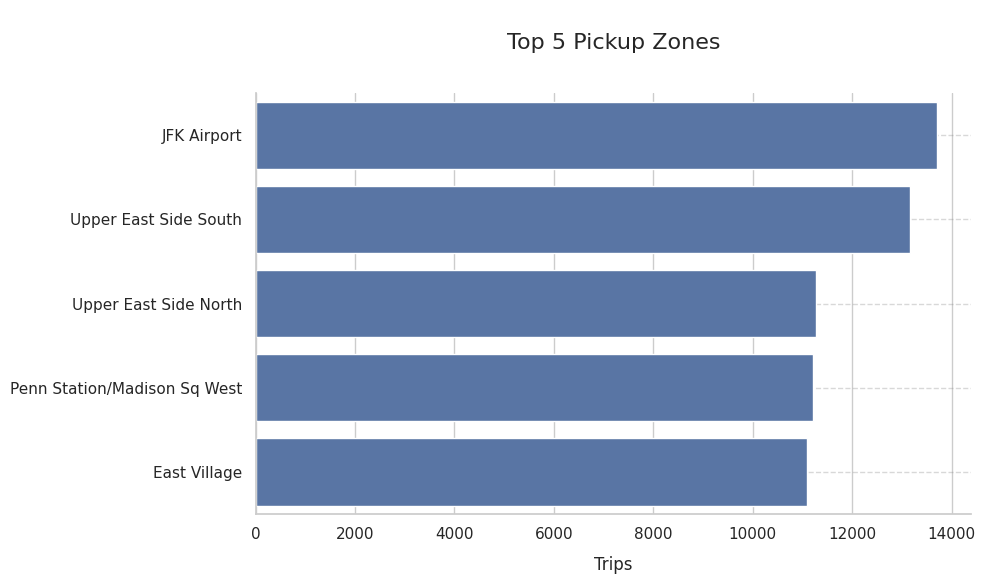

In [35]:
# 1. Top Pickup Zones
top_pickups = (
    df.groupby('pickup_zone')
    .size()
    .reset_index(name='trip_count')
    .sort_values('trip_count', ascending=False)
    .head(5)
)

fig, ax = plt.subplots()

sns.barplot(
    data=top_pickups,
    y='pickup_zone',
    x='trip_count',
    ax=ax
)

style_plot(
    ax,
    title="Top 5 Pickup Zones",
    xlabel="Trips",
    ylabel=""
)

save_plot(fig, 'fig01.png')

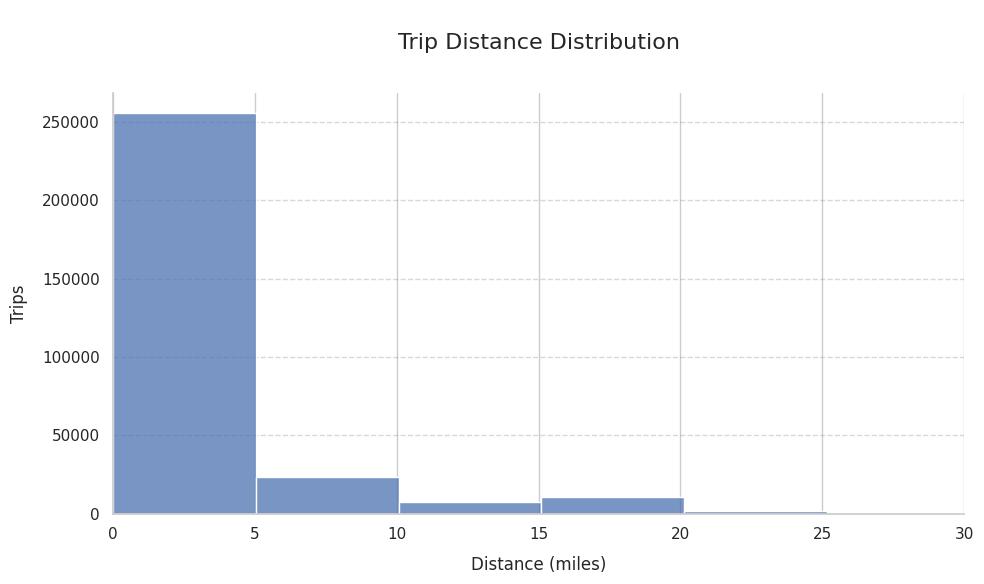

In [36]:
# 2. Trip Distance Distribution

fig, ax = plt.subplots()
# Bin distances
sns.histplot(df['trip_distance'], bins=50, ax=ax)
ax.set_xlim(0, 30)

style_plot(
    ax,
    title='Trip Distance Distribution',
    xlabel='Distance (miles)',
    ylabel='Trips'
)

save_plot(fig, 'fig02.png')

In [37]:
%%sql
CREATE OR REPLACE TABLE agg_hourly AS
WITH hourly AS (
    SELECT
        EXTRACT(hour FROM pickup_datetime) AS hour,
        COUNT(*) AS trips,
        SUM(fare_amount) AS total_fare,
        SUM(tip_amount) AS total_tips
    FROM fct_trips
    GROUP BY hour
),
totals AS (
    SELECT
        SUM(trips) AS total_trips,
        SUM(total_fare) AS overall_fare,
        SUM(total_tips) AS overall_tips
    FROM hourly
)
-- Admittedly, these names aren't great, but they're only used once below.
SELECT
    h.hour,
    h.trips,
    ROUND(100.0 * h.trips / t.total_trips, 2) AS pct_trips,
    h.total_fare,
    h.total_tips,
    ROUND(100.0 * h.total_tips / h.total_fare, 2) AS pct_tips
FROM hourly h
CROSS JOIN totals t
ORDER BY h.hour;

-- Quick check
SELECT
    'OK' AS status,
    (SELECT COUNT(hour) FROM agg_hourly) AS hourly;

Running query in 'duckdb:///:memory:'

,status,hourly
0,OK,24


Running query in 'duckdb:///:memory:'

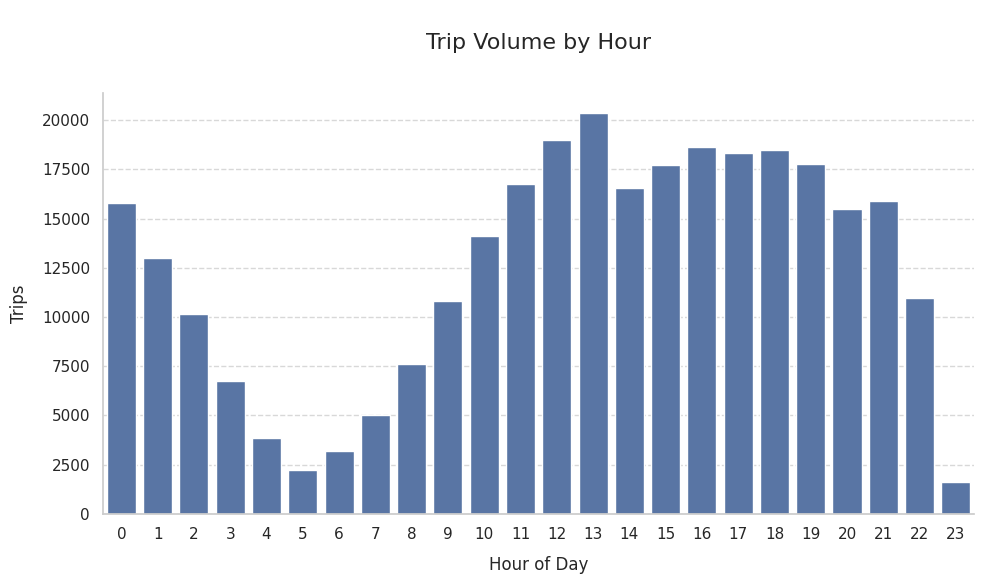

In [38]:
# 3. Trip Volume by Hour

'''
# Before using Pandas:

# Ensure pickup_hour exists
df['pickup_hour'] = pd.to_datetime(df['pickup_datetime']).dt.hour
hourly_counts = df.groupby('pickup_hour').size().reset_index(name='trip_count')
'''

# Now using SQL:
df = %sql SELECT hour AS pickup_hour, trips AS trip_count FROM agg_hourly ORDER BY hour

# Plot
fig, ax = plt.subplots()
sns.barplot(x='pickup_hour', y='trip_count', data=df, ax=ax)

style_plot(
    ax,
    title='Trip Volume by Hour',
    xlabel='Hour of Day',
    ylabel='Trips'
)

save_plot(fig, 'fig03.png')

Running query in 'duckdb:///:memory:'

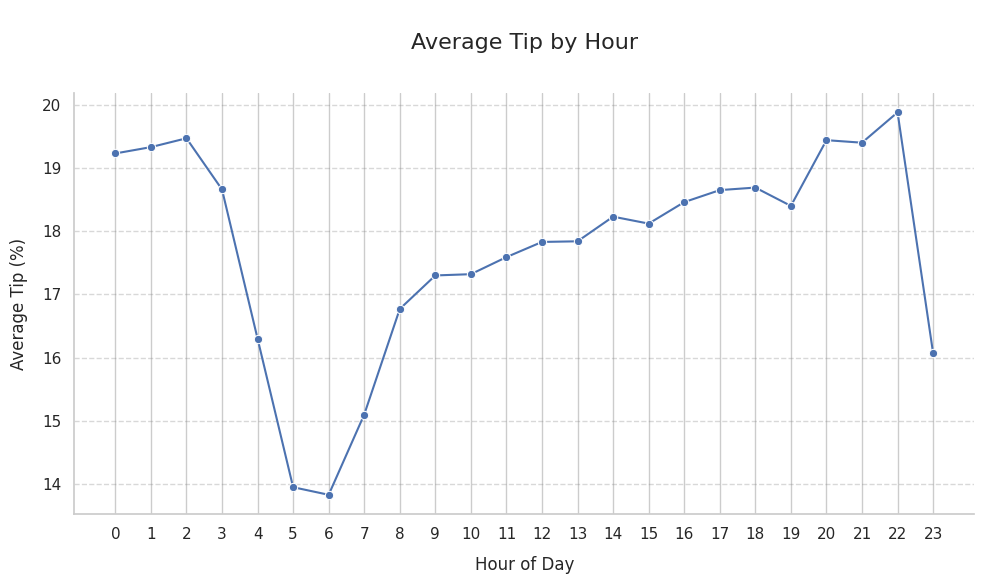

In [39]:
# 4. Tips by Hour

'''
# Before using Pandas:

# Ensure pickup_hour exists
df['pickup_hour'] = pd.to_datetime(df['pickup_datetime']).dt.hour
df['tip_percent'] = (df['tip_amount'] / df['fare_amount']) * 100
hourly_tips = df.groupby('pickup_hour')['tip_percent'].mean().reset_index()
'''

# Now using SQL
df = %sql SELECT hour, pct_tips FROM agg_hourly ORDER BY hour


fig, ax = plt.subplots()
sns.lineplot(
    x='hour',
    y='pct_tips',
    data=df,
    marker='o',
    ax=ax
)

ax.set_xticks(range(0, 24))
style_plot(
    ax,
    title="Average Tip by Hour",
    xlabel="Hour of Day",
    ylabel="Average Tip (%)"
)

save_plot(fig, 'fig04.png')

## Summary
- **JFK** remains a **top pickup zone**, consistently generating high volume due to airport demand.
- Most rides are **short intra-city trips**, with the majority **under 5 miles**.
- Ride counts rise through the day, peaking in the **evening around 5–6 PM**, then taper off overnight.
- Tips are generally stable, **peaking in the late evening (19–20%)** and **dipping in the early morning (~14–15%)**.